In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import filters
from skimage.feature import canny
# for finding continuous sequences in a list
from operator import itemgetter
from itertools import groupby

# change plot size
mpl.rcParams['figure.figsize'] = (15, 15)

## Image modifying functions

In [2]:
# read in an image
def readImg(filename, plotIt = False):
    # read in image file
    let = misc.imread(filename)
    # read it in as grey
    grey = misc.imread(filename, flatten=True)
    
    if plotIt:        
        plt.imshow(let)
        plt.show()
        plt.imshow(grey, cmap = "gray")
        plt.show()
    return let, grey

# project the image onto a specific direction
def project(img, direction):
    if direction == "x":
        proj = np.sum(img, 0)
    elif direction == "y":
        proj = np.sum(img, 1)
    else:
        print("Direction must be one of 'x' or 'y'")
        proj = []
    return proj

# binarize an image
def binarizeImg(img, biThresh, plotIt = False):
    imgCp = img.copy()
    if biThresh == "otsu":
        biThresh = filters.threshold_otsu(imgCp)
    inds = imgCp > biThresh
    imgCp[inds] = 1
    imgCp[np.logical_not(inds)] = 0
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# smooth an image
def smoothImg(img, smoothSigma, plotIt = False):
    imgCp = ndimage.filters.gaussian_filter(input=img, sigma=smoothSigma)
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp


In [3]:
def removeEdges(imgCol, imgGr, rmThresh = 0):
    imgGrCp = imgGr.copy()
    imgColCp = imgCol.copy()
    
    imgY = project(imgGrCp, "y")
    imgGrCp = imgGrCp[imgY > rmThresh]
    imgColCp = imgColCp[imgY > rmThresh]
    
    imgX = project(imgGrCp, "x")
    imgGrCp = imgGrCp[:,imgX > rmThresh]
    imgColCp = imgColCp[:,imgX > rmThresh]
    return imgColCp, imgGrCp

def whitenEdgesProject(grey):
    grey2 = smoothImg(grey, smoothSigma=1.0)
    brX = argrelextrema(project(grey2, "x"), np.greater_equal)[0]
    brX = [brX[0], brX[-1]]
    brY = argrelextrema(project(grey2, "y"), np.greater_equal)[0]
    brY = [brY[0], brY[-1]]
    greyCp = grey.copy()
    greyCp[:,:brX[0]] = 255
    greyCp[:,brX[1]:] = 255
    greyCp[:brY[0]] = 255
    greyCp[brY[1]:] = 255
    return greyCp

def whitenEdgesFilter(grey):
    grey2 = smoothImg(grey, smoothSigma=3.0)
    grey2 = 1 - binarizeImg(grey2, "otsu")
    labels, nrObj = ndimage.label(grey2)
    nr, nc = grey.shape
    wlabs = [labels[0, 0], labels[0, nc-1], labels[nr-1, 0],
             labels[nr-1, nc-1]]
    wlabs = np.unique(wlabs)
    greyCp = grey.copy()
    for la in wlabs:
        greyCp[labels == la] = 255
    return greyCp

## Plotting functions

In [117]:
# plot "histogram"
def densityHist(proj, pers = []):
    plt.plot(proj)
    ny = proj.shape[0]
    for pe in pers:
        p = np.percentile(proj, pe)
        plt.plot([0,ny], [p, p])
        plt.text(x=ny, y=p, s=str(pe))
    plt.show()

# plot boxes around words (or just linebreaks)
def plotBoxes(img, lb, wb = [], cb = [], cmap = None):
    if len(lb) == 0:
        lb = [0, img.shape[0]]
    plt.imshow(img, cmap=cmap)
    plt.plot([0,img.shape[1]], [lb, lb], 'b')
    if len(wb) > 0:
        for i in range(len(lb)-1):
            plt.plot([wb[i], wb[i]], [lb[i], lb[i+1]], 'b')
            if len(cb) > 0:
                for j in range(len(wb[i])-1):
                    plt.plot([np.add(wb[i][j], cb[i][j]), np.add(wb[i][j],cb[i][j])],
                             [lb[i], lb[i+1]], 'r')
    plt.show()

## Segmentation functions

In [5]:
# get breaks based on projection
def projBreaks(img, direction, thresh = 0):
    proj = project(img, direction)
    breaks = argrelextrema(proj, np.greater_equal)[0]
    breaks = breaks[breaks > thresh-1]
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == proj.shape[0]:
        breaks = np.append(breaks, proj.shape[0]) 
    return breaks.astype("int")

# get the breaks based on canny edge detection
def edgeBreaks(img, direction, thresh = 0, cpar = [5, 1, 25]):
    edges = canny(img, cpar[0], cpar[1], cpar[2])
    eproj = project(edges, direction)
    br = np.sort(np.where(eproj <= thresh)[0])
    # get middle (mean) of continuous sequences
    breaks = []
    for k, g in groupby(enumerate(br), lambda ix:ix[0]-ix[1]):
        group = list(map(itemgetter(1), g))
        breaks.append(np.mean(group))
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == eproj.shape[0]:
        breaks = np.append(breaks, eproj.shape[0]) 
    return breaks.astype("int")

## Save images

In [141]:
import csv
# save all segments to a folder
def saveSegments(img, lb, wb, fname, cb = [], folder = "./",
                 ftype = ".png"):
    prefix = folder + fname
    writeit = csv.writer(open(prefix+"_manifest.csv", "w"))
    writeit.writerow(["origImg", "imgLoc"])
    for i in range(len(lb)-1):
        if lb[i+1] - lb[i] < 5:
            continue
        for j in range(len(wb[i])-1):
            if wb[i][j+1] - wb[i][j] < 5:
                continue
            colrow = str(int(lb[i])) + "_" + str(int(wb[i][j]))
            nm = prefix + "_" + colrow + ftype
            writeit.writerow([fname, fname+"_" + colrow + ftype])
            chunk = img[lb[i]:lb[i+1], wb[i][j]:wb[i][j+1]]
            if len(cb) > 0:
                for k in range(len(cb[i][j])):
                    for h in range(chunk.shape[0]):
                        if cb[i][j][k] < chunk.shape[1]:
                            chunk[h,cb[i][j][k]] = [0,0,255]
#                 plt.plot([np.add(wb[i][j], cb[i][j]), np.add(wb[i][j],cb[i][j])],
#                              [lb[i], lb[i+1]], 'r')
            misc.imsave(nm, chunk)

## Run segmentation on a couple of images

In [142]:
# some parameters for testing
plotIt1=False
plotIt2=False
plotIt3=False
fname = "images/easy1.jpg"
outFname = "easy1"

# read in and do all pre-processing
let, grey = readImg(fname, plotIt=plotIt1)
let, grey = removeEdges(let, grey, rmThresh=0)
greyBi = binarizeImg(grey, biThresh="otsu", plotIt=plotIt1)
greySm = smoothImg(grey, smoothSigma=5.0, plotIt=plotIt1)
greyBiSm = smoothImg(greyBi, smoothSigma=5.0, plotIt=plotIt1)

# get linebreaks
lbSm = projBreaks(greySm, "y")
lbBiSm = projBreaks(greyBiSm, "y")
if plotIt2:
    plotBoxes(let, lbSm)
    plotBoxes(let, lbBiSm) # this one seems to be better
lb = lbBiSm.copy()

# get wordbreaks
wbEdge = []
wbProj = []
for i in range(len(lb)-1):
    chunkEdge = grey[lb[i]:lb[i+1],]
    wbEdge.append(edgeBreaks(chunkEdge, "x", cpar=[6,1,25]))
    
    chunkProj = greyBiSm[lb[i]:lb[i+1],]
    wbProj.append(projBreaks(chunkProj, "x"))

if plotIt3:
    plotBoxes(let, lb, wbEdge)
    plotBoxes(let, lb, wbProj)

greySm2 = smoothImg(grey, smoothSigma=4.0, plotIt=plotIt1)
cb = []
for i in range(len(lb)-1):
    curb = []
    for j in range(len(wb[i])-1):
#         chunk = greySm[lb[i]:lb[i+1], wbEdge[i][j]:wbEdge[i][j+1]]
#         curb.append(edgeBreaks(chunk, "x", cpar = [1,1,25]))
        chunk = greySm2[lb[i]:lb[i+1], wbEdge[i][j]:wbEdge[i][j+1]]
        curb.append(projBreaks(chunk, "x"))
    cb.append(curb)
# print(cb)
# plotBoxes(let, lb, wbEdge, cb)
saveSegments(let, lb, wbEdge, outFname, cb, "segmented_img/")

## Try scale space-gaussian approach

In [43]:
# some parameters for testing
plotIt1=False
plotIt2=False
plotIt3=True
fname = "images/easy1.jpg"
outFname = "easy1"

# read in and do all pre-processing
let, grey = readImg(fname, plotIt=plotIt1)
let, grey = removeEdges(let, grey, rmThresh=0)
grey = whitenEdgesProject(grey)
greyBi = binarizeImg(grey, biThresh="otsu", plotIt=plotIt1)
greySm = smoothImg(grey, smoothSigma=5.0, plotIt=plotIt1)
greyBiSm = smoothImg(greyBi, smoothSigma=5.0, plotIt=plotIt1)


# get linebreaks
lb = projBreaks(greyBiSm, "y")
# plotBoxes(let, lb)

# get wordbreaks
nu = 3.5
sigYs = np.arange(1, 8, 0.3)
sigXs = sigYs * nu

6


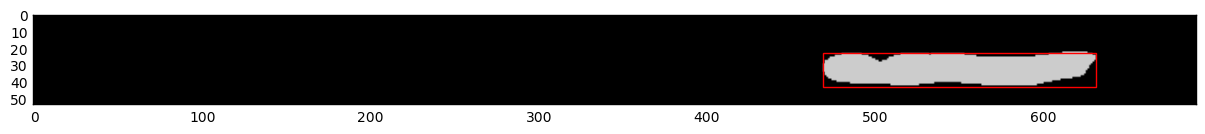

2


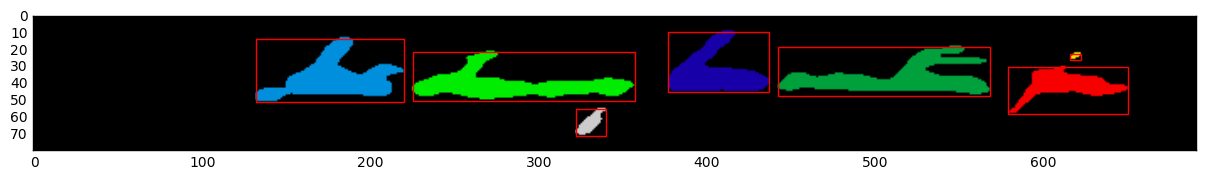

3


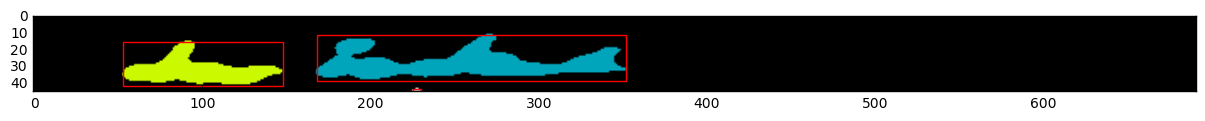

1


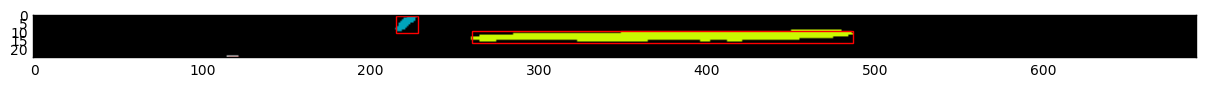

1


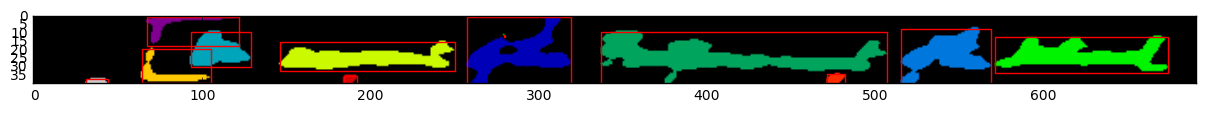

2


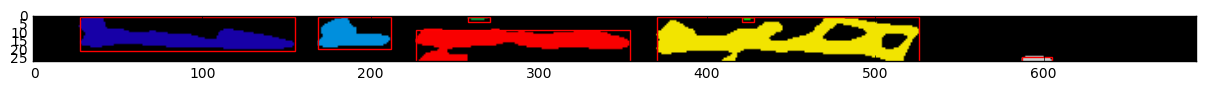

3


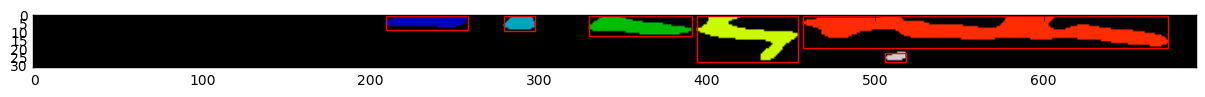

2


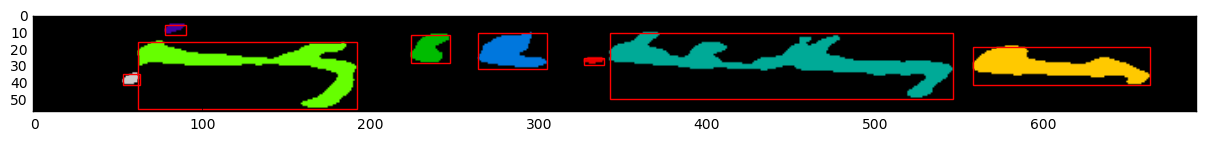

2


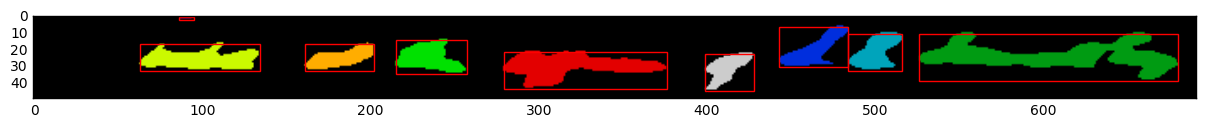

3


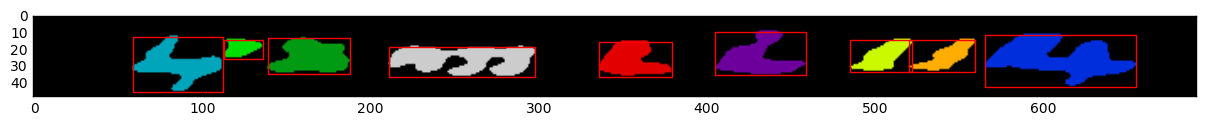

2


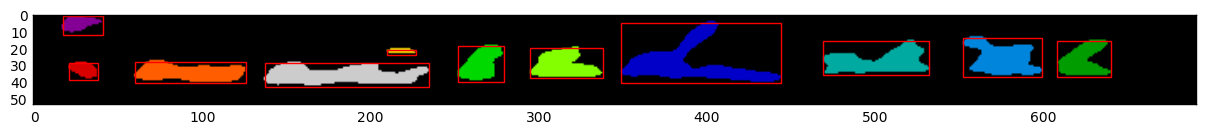

2


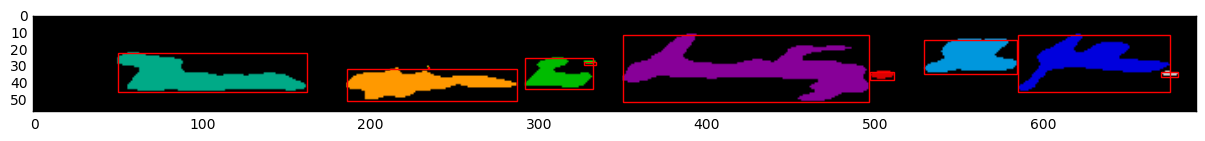

2


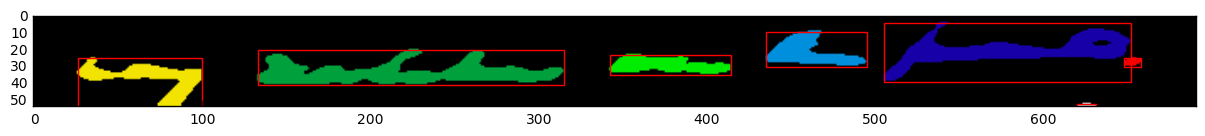

4


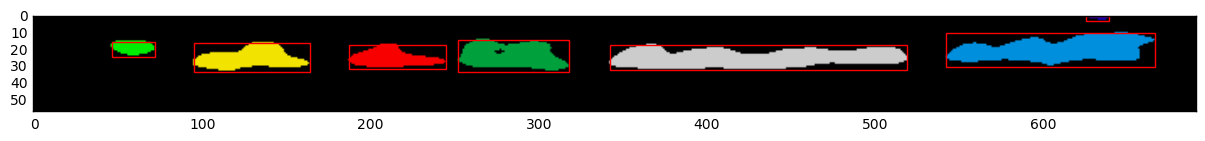

3


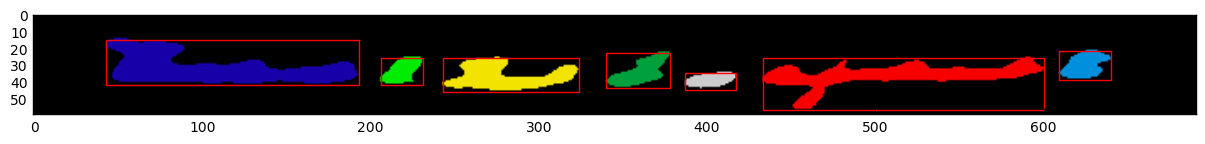

2


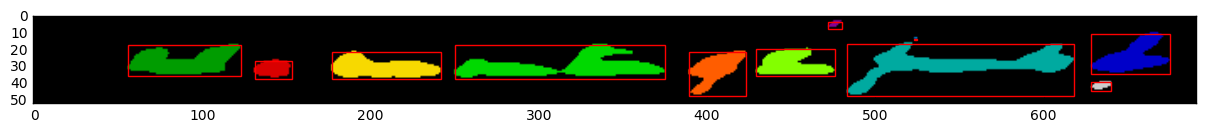

2


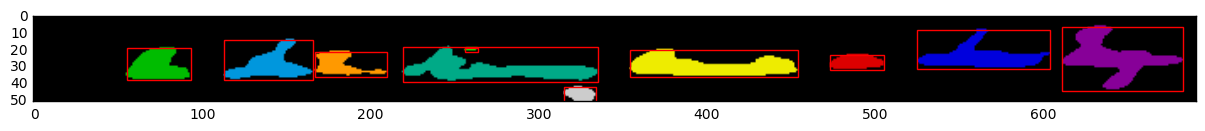

2


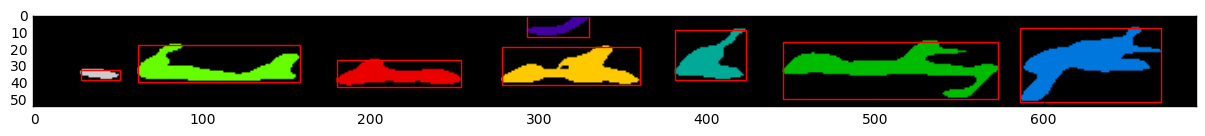

4


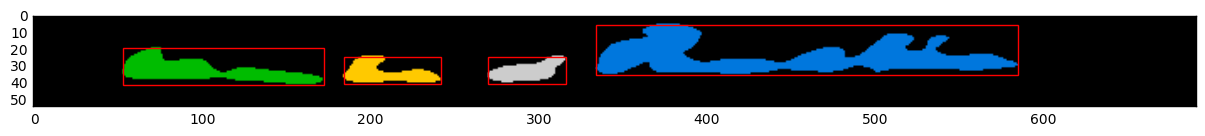

2


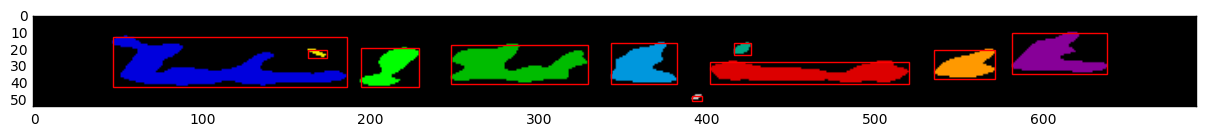

2


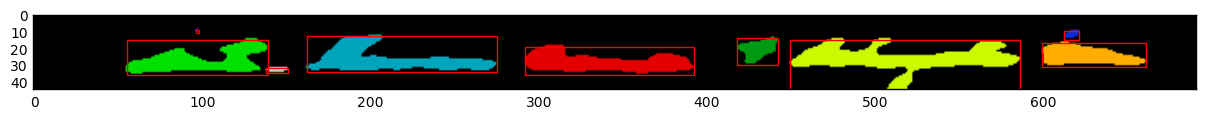

3


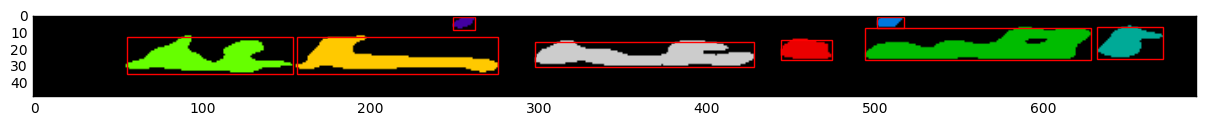

In [99]:
from scipy.ndimage.filters import gaussian_filter1d as gf1
from scipy.ndimage.filters import gaussian_filter as gf
wbScale = []
for i in range(len(lb)-1):
#     i = 3
    chunk = greyBi[lb[i]:lb[i+1],]
    if chunk.shape[0] <= 1:
        continue
    extents = []
    count = 0
    for j in range(len(sigYs)):
        filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]), order=0)
        if count < 2:
            th = filters.threshold_otsu(filt)
            count += 1
        binfilt = binarizeImg(filt, th)
    #     plotBoxes(binfilt, lb=[], wb=wbScale, cmap="gray")
        extents.append(np.sum(binfilt))
    j = np.argmin(extents)
    print(j)
    #     j = 4
    filt = ndimage.filters.gaussian_filter(input=chunk, sigma=(sigYs[j],sigXs[j]))
    binfilt = binarizeImg(filt, th)
    #     plotBoxes(binfilt, lb=[], wb=wbScale, cmap="gray")

    # find pieces
    binfilt2 = 1 - binfilt
    labels, nrObj = ndimage.label(binfilt2)
#     plt.imshow(labels, cmap='spectral')
#     plt.show()
    osli = ndimage.find_objects(labels)
    rec = []
    sh = np.max(labels.shape)
    for sl in osli:
        sl0 = sl[0].indices(sh)
        sl1 = sl[1].indices(sh)
        sl2 = np.subtract(sl1, sl0)
        rec.append([[sl1[0], sl0[0]], sl1[1]-sl1[0], sl0[1]-sl0[0]])
    fit,ax = plt.subplots(1)
    ax.imshow(labels, cmap='spectral')
    for i in range(len(rec)):
        rect = mpl.patches.Rectangle(rec[i][0], rec[i][1], rec[i][2], linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    plt.show()
# https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html

# Misc code

In [ ]:
# save a couple functions I might use eventually but are too general now

# read in and do all pre-processing
def readAndPrep(filename, rmThresh = 0, biThresh = "otsu",
                smoothSigma = 5.0, plotIt = False):
    let, grey = readImg(filename, plotIt)
    let, grey = removeEdges(let, grey, rmThresh)
    greyBi = binarizeImg(grey, biThresh, plotIt)
    greySm = smoothImg(grey, smoothSigma, plotIt)
    return let, grey, greyBi, greySm

# split into words
def getWordBreaks(img, lineBreaks, method = "edge", thresh = 0):
    wordbreaks = []
    for i in range(len(lineBreaks)-1):
        chunk = img[lineBreaks[i]:lineBreaks[i+1],]
        if method == "edge":
            wordbreaks.append(edgeBreaks(chunk, "x", thresh))
        elif method == "proj":
            wordbreaks.append(projBreaks(chunk, "x", thresh))
    return wordbreaks

# segment the whole document
def segmentDoc(origImg, grImg1, grImg2, m1 = "proj", m2 = "edge",
               th1 = 0, th2 = 0, plotIt = True):
    # get line breaks
    if m1 == "proj":
        lineBreaks = projBreaks(grImg1, "y", th1)
    elif m1 == "edge":
        lineBreaks = edgeBreaks(grImg1, "x", th1)
    # get word breaks
    wordBreaks = getWordBreaks(grImg2, lineBreaks, m2, th2)
    # plot the image
    if plotIt:
        plotBoxes(origImg, lineBreaks, wordBreaks)
    return lineBreaks, wordBreaks

In [ ]:
# looking at Otsu filter with smoothing (got a weird result once)
let, grey = readImg("images/easy1.jpg")
let, grey = removeEdges(let, grey)
grBi = binarizeImg(grey, "otsu")
grSm = smoothImg(grey, 5)
plt.imshow(grSm, cmap="gray")
plt.plot([0, grSm.shape[1]], [projBreaks(grSm, "y"), projBreaks(grSm, "y")])
plt.show()